### Single spin in magnetic field

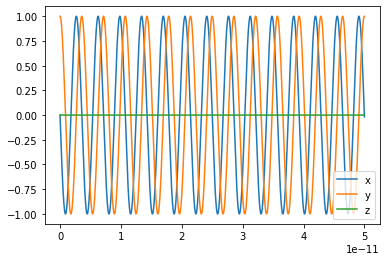

In [1]:
%matplotlib inline
import numpy as np
from ase.atoms import Atoms
from minimulti.spin import SpinHamiltonian
from minimulti.spin import SpinMover
import matplotlib.pyplot as plt

def test_single_spin():
    """
    Isolated spin in an applied field. field:10T, time step: 1fs.
    Total time: 100 ps, No Langevin term.
    """
    # make model
    atoms = Atoms(symbols="H", positions=[[0, 0, 0]], cell=[1, 1, 1])
    spin = np.array([[0, 1, 0]], dtype=float)

    ham = SpinHamiltonian(
        cell=atoms.cell,
        pos=atoms.get_scaled_positions(),
        spinat=spin,
        zion=atoms.get_atomic_numbers())
    ham.set(gilbert_damping=[0.0])
    ham.set_external_hfield([0, 0.0, 10.0])

    mover = SpinMover(hamiltonian=ham, s=spin, write_hist=True)
    mover.set(
        time_step=0.01,
        temperature=0.0,
        total_time=50,
        save_all_spin=True)

    mover.run(write_step=1, method='DM')

    hist = mover.get_hist()

    hspin = np.array(hist['spin'])
    time = np.array(hist['time'])

    plt.plot(time, hspin[:, 0, 0], label='x')
    plt.plot(time, hspin[:, 0, 1], label='y')
    plt.plot(time, hspin[:, 0, 2], label='z')
    plt.legend()
    plt.show()


test_single_spin()

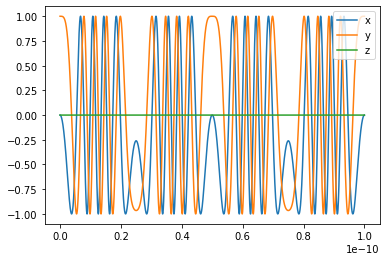

In [2]:
%matplotlib inline
import numpy as np
from ase.atoms import Atoms
from minimulti.spin import SpinHamiltonian
from minimulti.spin import SpinMover
import matplotlib.pyplot as plt
from minimulti.math.geometry import rotate_vec

def Hext_func1(pos, t):
    w=2*np.pi/5e-11 # 10 ps
    return np.array([0.0, 0.0, 10*np.sin(w*t)])

def Hext_func2(pos, t):
    """
    This is a magnetic field rotating around z with angular frequency w.
    """
    w=2*np.pi/5e-11 # 50 ps
    vec=np.array([0,0,10.0]) # 10 Tesla along z
    vec=rotate_vec(np.pi*0.35, np.array([1.0,0.0,0.0]), vec) # rotate around x by 0.1 rad
    vec=rotate_vec(w*t, np.array([0.0,0.0,1.0]), vec) # the rotate aroung z by wt
    return vec


def test_single_spin(Hext_func=Hext_func1):
    """
    Isolated spin in an applied field. field:10T, time step: 1fs.
    Total time: 100 ps, No Langevin term.
    """
    # make model
    atoms = Atoms(symbols="H", positions=[[0.5, 0.5, 0.5]], cell=[1, 1, 1])
    spin = np.array([[0, 1, 0]], dtype=float)

    ham = SpinHamiltonian(
        cell=atoms.cell,
        pos=atoms.get_scaled_positions(),
        spinat=spin,
        zion=atoms.get_atomic_numbers())
    ham.set(gilbert_damping=[0.0])
    #ham.set_external_hfield([0, 0.0, 10.0])
    ham.set_dynamic_external_field(Hext_func)
    mover = SpinMover(hamiltonian=ham, s=spin, write_hist=True)
    mover.set(
        time_step=0.01,
        temperature=0.01,
        total_time=100,
        save_all_spin=True)

    mover.run(write_step=1, method='HeunP')

    hist = mover.get_hist()

    hspin = np.array(hist['spin'])
    time = np.array(hist['time'])

    plt.plot(time, hspin[:, 0, 0], label='x')
    plt.plot(time, hspin[:, 0, 1], label='y')
    plt.plot(time, hspin[:, 0, 2], label='z')
    plt.legend()
    plt.show()


test_single_spin()

In [3]:
%matplotlib inline
from minimulti.spin.hist_file import read_hist
import numpy as np
import ipyvolume as ipv

def show_spin(fname):
    hist=read_hist(fname)
    pos=hist["positions"]
    s=hist["spin"]
    ipv.figure()
    x,y,z=np.array(pos).T
    #vx, vy, vz=np.array(s).T
    
    vx=s[:,:,0]
    vy=s[:,:,1]
    vz=s[:,:,2]
    #ipv.quickscatter(x,y,z, size=1, marker='sphere')
    q=ipv.quiver(x, y, z, vx, vy, vz, size=40)
    ipv.animation_control(q, interval=1)
    #ipv.style.use(["dark","minimal"])
    ipv.show()
#show_spin('./Spinhist.nc')  
show_spin('/home/hexu/projects/minimulti/examples/Spinhist.nc') 

/home/hexu/.local/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


### Spin dimer

In [4]:
%matplotlib inline
import numpy as np
from ase.atoms import Atoms
from minimulti.spin import SpinHamiltonian
from minimulti.spin import SpinMover, SpinModel
import matplotlib.pyplot as plt
from minimulti.math.geometry import rotate_vec
from minimulti.constants import mu_B, eV
from ase.units import kB, fs
from minimulti.lattice import Lattice
from minimulti.spin_lattice_coupling.slc import (SpinLatticeCoupling, OijuTerm,
                                                 TijuvTerm)
from minimulti.spin_lattice_model.spin_lattice_model import SpinLatticeModel
from minimulti.abstract.datatype import Rijv
import copy
import os
meV=1e-3*eV
ps=1e3*fs

atoms = Atoms(symbols="H2", positions=[[0.25, 0.5, 0.5], [0.75, 0.5,0.5]], cell=[1, 1, 1])

def build_spin_ham(Jval=1e-23):
    spin = np.array([[0, 0.6, 0.8], [0,-0.6,0.8]], dtype=float)

    ham = SpinHamiltonian(
        cell=atoms.cell,
        pos=atoms.get_scaled_positions(),
        spinat=spin,
        zion=atoms.get_atomic_numbers())
    J={(0, 1,(0,0,0)): Jval,
       (1, 0,(0,0,0)): Jval,
      }
    ham.set_exchange_ijR(J)
    ham.set(gilbert_damping=[0.0,0.0])
    spin_model=SpinModel(ham=ham)
    return spin_model

def build_lattice_ham(w):
    k=w**2
    # 2*3 (3D)
    ifc=Rijv(shape=(6, 6))
    # interaction along x direction.
    ifc.add(R=(0,0,0), i=0, j=0, val=k)
    ifc.add(R=(0,0,0), i=3, j=3, val=k)
    ifc.add(R=(0,0,0), i=0, j=3, val=-k)
    ifc.add(R=(0,0,0), i=3, j=0, val=-k)
    # atoms with displacement for initial state.
    ref_atoms=copy.deepcopy(atoms)
    c_atoms = Atoms(symbols="H2", positions=[[0.2, 0.5, 0.5], [0.8, 0.5,0.5]])
    latt=Lattice(ifc=ifc, ref_atoms=ref_atoms, atoms=c_atoms)
    #latt.plot_phonon_band()
    #plt.show()
    return latt

def build_Oiju(val):
    #           i  j  u   val
    Oiju_dict={(0, 1, 0): val,
               (0, 1, 3): -val,
               (1, 0, 0): val,
               (1, 0, 3): -val
              }
    # all Rj and Ru=(0,0,0)
    ilist=np.array([0,0,1,1], dtype=int)
    jlist=[1,1,0,0]
    ulist=[0,3,0,3]
    vallist=np.array([1,-1,1,-1])*val
    Rjlist=np.repeat(np.array([[0,0,0]]), 4, axis=0)
    Rulist=np.repeat(np.array([[0,0,0]]), 4, axis=0)
    Sref=np.array([[0,0,1],
                  [0,0,1]], dtype=float)
    Oiju=OijuTerm(nspin=2, natom=2, ndata=4, ilist=ilist, jlist=jlist, ulist=ulist,
                 Rjlist=Rjlist, Rulist=Rulist, vallist=vallist, Sref=Sref)
    #print(Oiju.Sref)
    splatt_term = SpinLatticeCoupling(ms=[1,1], natom=2, Sref=Sref)
    splatt_term.add_term(Oiju, name='Oiju')
    return splatt_term

def build_slc_model(Jval=3e-22, w=2*np.pi/(40*ps), Oiju_val=2e-5, total_time=100, time_step=1e-3):
    spin_model=build_spin_ham(Jval=Jval)
    lattice_model=build_lattice_ham(w=w)
    splatt_model=build_Oiju(val=Oiju_val)
    c_atoms = Atoms(symbols="H2", positions=[[0.2, 0.5, 0.5], [0.8, 0.5,0.5]])
    sp_latt_model = SpinLatticeModel(
        lattice_model=lattice_model,
        spin_model=spin_model,
        spin_lattice_coupling=splatt_model, 
        atoms=c_atoms)
    
    sp_latt_model.set_spin_params(
        temperature=0, time_step=time_step, total_time=100)
    sp_latt_model.set_lattice_params(
        md='NVE',
        lattice_temperature=0 * kB,
        lattice_time_step=time_step * ps,
        lattice_friction=0.002)
    vec0=rotate_vec(np.pi*0.05, np.array([0.0,1.0,0.0]), np.array([0.0,0.6,0.8]))
    spin = np.array([np.array(vec0), [0,-0.6,0.8]], dtype=float)
   

    sp_latt_model._spin_model.mover.s=spin
    if not os.path.exists("splatt_traj"):
        os.makedirs("splatt_traj")
    temps=[]
    #sp_latt_model.run(20, md='Langevin')
    print(int(total_time//time_step))
    for step in range(int(total_time//time_step)):
        #print(step)
        sp_latt_model.run(1)
        #write('splatt_traj2/atom%03d.xyz' % step, sp_latt_model.atoms)
        #print("Lattice Temperature:",get_atoms_temperature(sp_latt_model.atoms))
        #temps.append(get_atoms_temperature(sp_latt_model.atoms))
    sp_latt_model._spin_model.mover.close_hist()
    return sp_latt_model


FileNotFoundError: [Errno 2] No such file or directory: '/Users/hexu/projects/SrMnO3/scripts/model/POSCAR'

In [ ]:
from ase.io.trajectory import Trajectory

def plot_latt(fname, ax=None, time_step=1e-3):
    if ax is None:
        fig, ax=plt.subplots()
    traj=Trajectory(fname)
    positions=[t.get_positions() for t in traj]
    positions=np.array(positions)
    time=np.arange(len(positions))*time_step
    ax.plot(time,positions[:,0,0], label='x')
    ax.plot(time,positions[:,0,1], label='y')
    ax.plot(time,positions[:,0,2], label='z')
    ax.set_xlabel('Time (ps)')
    ax.legend()
    plt.show()
    
def run_dimer():
    model=build_slc_model(Jval=3e-22, w=2*np.pi/(4*ps), Oiju_val=6e-4, total_time=15, time_step=2e-3)

    hist = model._spin_model.mover.get_hist()

    hspin = np.array(hist['spin'])
    time = np.array(hist['time'])/1e-12

    plt.plot(time, hspin[:, 0, 0], label='x')
    plt.plot(time, hspin[:, 0, 1], label='y')
    plt.plot(time, hspin[:, 0, 2], label='z')
    plt.xlabel('Time (ps)')
    plt.legend()
    plt.show()
run_dimer()
plot_latt('./LattHist.traj')

In [ ]:
2*np.pi